In [ ]:
!pip install dask==0.15.1
!pip install h5py==2.5.0
!pip install keras==2.0.4

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import os
import librosa as lr
import shutil
import dask.array as da
from dask.array.image import imread
import h5py
import glob

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from scipy.misc import imresize
import keras
from keras import regularizers
from keras.optimizers import SGD, Nadam
from keras.models import Sequential, Model, load_model
from keras.layers import Activation, concatenate, add, GRU, LSTM ,Dense, Flatten, InputLayer, Dropout, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, Input, Conv1D, Reshape
from keras.preprocessing.image import ImageDataGenerator

In [31]:
def mp3_to_img(path, height=64, width=64):
    signal, sr = lr.load(path, res_type='kaiser_fast')
    hl = signal.shape[0]//(width) #this will cut away 5% from start and end
    spec = lr.feature.melspectrogram(signal, n_mels=height, hop_length=int(hl))
    img = lr.logamplitude(spec)**2
    start = (img.shape[1] - width) // 2
    return img[:, start:start+width]

In [32]:
train = pd.read_csv('data/train_list.csv').sample(frac=1).reset_index(drop=True)
train.phonetics.value_counts()

n       976
ka      878
o       858
i       824
u       822
gya     784
to      775
shi     725
ko      673
ma      662
hi      633
ku      630
nyu     606
no      583
cha     564
na      560
mo      558
ji      555
mi      543
ta      538
ni      509
ki      509
tsu     508
ne      493
go      493
ha      491
sa      488
ri      487
a       485
chi     484
       ... 
pe      394
pi      394
pu      393
fa      393
nyo     392
pyu     392
pya     392
myu     392
mya     392
wi      392
po      392
hyu     392
ja      392
nya     392
gyo     392
rya     392
bya     392
chu     392
myo     392
dash    392
kya     392
ju      392
pyo     392
byu     392
pa      392
we      392
wo      392
kyu     392
hya     392
hyo     392
Name: phonetics, dtype: int64

In [33]:
temp_x = []
temp_y = []

for index, row in train.iterrows():
    img_name = row['filename']
    img_path = os.path.join('data/jpg/', img_name + '.jpg')
    img = imread(img_path) #mp3_to_img(os.path.join('data/raw/', img_name + '.wav'))
    #img = imresize(img, (60, 12), interp='nearest')
    img = img.reshape(36, 96, 1)
    temp_x.append(img.astype('int'))
    
all_x = np.stack(temp_x)

#all_x = all_x / 255.

In [34]:
train.phonetics.value_counts()

n       976
ka      878
o       858
i       824
u       822
gya     784
to      775
shi     725
ko      673
ma      662
hi      633
ku      630
nyu     606
no      583
cha     564
na      560
mo      558
ji      555
mi      543
ta      538
ni      509
ki      509
tsu     508
ne      493
go      493
ha      491
sa      488
ri      487
a       485
chi     484
       ... 
pe      394
pi      394
pu      393
fa      393
nyo     392
pyu     392
pya     392
myu     392
mya     392
wi      392
po      392
hyu     392
ja      392
nya     392
gyo     392
rya     392
bya     392
chu     392
myo     392
dash    392
kya     392
ju      392
pyo     392
byu     392
pa      392
we      392
wo      392
kyu     392
hya     392
hyo     392
Name: phonetics, dtype: int64

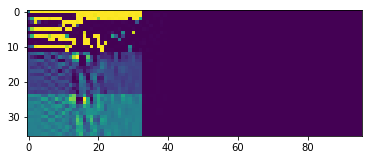

255


In [36]:
test_img = all_x[0, :, :, 0]
plt.imshow(test_img)
plt.show()

print(all_x[0, 0, 10, 0])

In [37]:
lb = LabelEncoder()
all_y = lb.fit_transform(train.phonetics)
all_y = keras.utils.np_utils.to_categorical(all_y)
print(list(lb.classes_))

with open('./data/classes.txt', 'wb') as fp:
    fp.write("\n".join(list(lb.classes_)).encode('utf-8'))
    
print(len(all_x))
print(len(all_y))





['a', 'ba', 'be', 'bi', 'bo', 'bu', 'bya', 'byo', 'byu', 'cha', 'chi', 'cho', 'chu', 'da', 'dash', 'de', 'do', 'e', 'fa', 'fu', 'ga', 'ge', 'gi', 'go', 'gu', 'gya', 'gyo', 'gyu', 'ha', 'he', 'hi', 'ho', 'hya', 'hyo', 'hyu', 'i', 'ja', 'ji', 'jo', 'ju', 'ka', 'ke', 'ki', 'ko', 'ku', 'kya', 'kyo', 'kyu', 'ma', 'me', 'mi', 'mo', 'mu', 'mya', 'myo', 'myu', 'n', 'na', 'ne', 'ni', 'no', 'nu', 'nya', 'nyo', 'nyu', 'o', 'pa', 'pe', 'pi', 'po', 'pu', 'pya', 'pyo', 'pyu', 'ra', 're', 'ri', 'ro', 'ru', 'rya', 'ryo', 'ryu', 'sa', 'se', 'sha', 'shi', 'sho', 'shu', 'so', 'su', 'ta', 'te', 'to', 'tsu', 'u', 'wa', 'we', 'wi', 'wo', 'xtsu', 'ya', 'yo', 'yu', 'za', 'ze', 'zo', 'zu']
50784
50784


In [38]:
tr_size = 48784
va_size = 1000
te_size = 1000

train_x = all_x[:tr_size]
train_y = all_y[:tr_size]

validation_x = all_x[tr_size:tr_size+va_size]
validation_y = all_y[tr_size:tr_size+va_size]

test_x = all_x[tr_size+va_size:]
test_y = all_y[tr_size+va_size:]

In [39]:
print(train_x.shape[0])
print(train_x.shape[1])
print(train_x.shape[2])
print(train_x.shape[3])
#train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2] * train_x.shape[3])

48784
36
96
1


In [40]:
input_num_units = (36, 96, 1)
hidden_num_units = 200
output_num_units = len(train.phonetics.value_counts())

epochs = 10
batch_size = 128

In [41]:
i = Input(shape=input_num_units)
m = Conv2D(16, (3, 3), activation='elu', padding='same')(i)
m = MaxPooling2D()(m)
m = Conv2D(32, (3, 3), activation='elu', padding='same')(m)
m = MaxPooling2D()(m)
m = Conv2D(64, (3, 3), activation='elu', padding='same')(m)
m = MaxPooling2D()(m)
m = Conv2D(128, (3, 3), activation='elu', padding='same')(m)
m = MaxPooling2D()(m)
m = Conv2D(256, (3, 3), activation='elu', padding='same')(m)
m = MaxPooling2D()(m)
m = Flatten()(m)
m = Dense(512, activation='elu')(m)
m = Dropout(0.5)(m)
o = Dense(output_num_units, activation='softmax')(m)

model = Model(inputs=i, outputs=o)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 36, 96, 1)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 36, 96, 16)        160       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 18, 48, 16)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 18, 48, 32)        4640      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 9, 24, 32)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 9, 24, 64)         18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 4, 12, 64)         0         
__________

In [42]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 36, 96, 1)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 36, 96, 16)        160       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 18, 48, 16)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 18, 48, 32)        4640      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 9, 24, 32)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 9, 24, 64)         18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 4, 12, 64)         0         
__________

In [43]:
#model = load_model('MinimalSpellingBee.h5')

In [44]:
model.compile(loss='categorical_crossentropy', optimizer=Nadam(lr=1e-3), metrics=['categorical_accuracy', 'top_k_categorical_accuracy'])
model.fit(train_x, train_y, epochs=5, verbose=1, validation_data=(validation_x, validation_y))
model.compile(loss='categorical_crossentropy', optimizer=Nadam(lr=1e-4), metrics=['categorical_accuracy', 'top_k_categorical_accuracy'])
model.fit(train_x, train_y, epochs=5, verbose=2, validation_data=(validation_x, validation_y))

Train on 48784 samples, validate on 1000 samples
Epoch 1/5
48784/48784 [==============================] - 30s - loss: 3.2187 - categorical_accuracy: 0.2089 - top_k_categorical_accuracy: 0.5208 - val_loss: 2.1615 - val_categorical_accuracy: 0.3620 - val_top_k_categorical_accuracy: 0.7600

In [23]:
sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy', 'top_k_categorical_accuracy'])

In [24]:
epochs=10
model.fit(train_x, train_y, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(validation_x, validation_y))

Train on 47618 samples, validate on 1000 samples
Epoch 1/10
47618/47618 [==============================] - 14s - loss: 0.1713 - categorical_accuracy: 0.9334 - top_k_categorical_accuracy: 0.9959 - val_loss: 0.9647 - val_categorical_accuracy: 0.7520 - val_top_k_categorical_accuracy: 0.9600

In [ ]:

128 - 0.7330

In [25]:
model.save('MinimalSpellingBee2.h5')

In [ ]:
model.summary()

In [45]:
epochs = 5
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy', 'top_k_categorical_accuracy'])
datagen = ImageDataGenerator(width_shift_range=0.1)

datagen.fit(train_x)
model.fit_generator(datagen.flow(train_x, train_y, batch_size=batch_size),
                    steps_per_epoch=len(train_x) / batch_size, epochs=epochs, 
                    verbose=2)

Epoch 1/5
19s - loss: 1.7112 - categorical_accuracy: 0.5343 - top_k_categorical_accuracy: 0.8527
Epoch 2/5
19s - loss: 1.4479 - categorical_accuracy: 0.5805 - top_k_categorical_accuracy: 0.8874
Epoch 3/5
19s - loss: 1.3233 - categorical_accuracy: 0.6085 - top_k_categorical_accuracy: 0.9042
Epoch 4/5
19s - loss: 1.2519 - categorical_accuracy: 0.6267 - top_k_categorical_accuracy: 0.9135
Epoch 5/5
19s - loss: 1.1825 - categorical_accuracy: 0.6437 - top_k_categorical_accuracy: 0.9195


In [46]:
datagen.fit(train_x)
model.fit_generator(datagen.flow(train_x, train_y, batch_size=batch_size),
                    steps_per_epoch=len(train_x) / batch_size, epochs=epochs, 
                    verbose=1)
model.save('MinimalSpellingBee.h5')

Epoch 1/5
382/381 [==============================] - 20s - loss: 1.1389 - categorical_accuracy: 0.6552 - top_k_categorical_accuracy: 0.9246     

In [ ]:
datagen.fit(train_x)
model.fit_generator(datagen.flow(train_x, train_y, batch_size=batch_size),
                    steps_per_epoch=len(train_x) / batch_size, epochs=epochs, 
                    verbose=2)
model.save('MinimalSpellingBee.h5')

In [ ]:
datagen.fit(train_x)
model.fit_generator(datagen.flow(train_x, train_y, batch_size=batch_size),
                    steps_per_epoch=len(train_x) / batch_size, epochs=epochs, 
                    verbose=2)
model.save('MinimalSpellingBee.h5')

In [ ]:
datagen.fit(train_x)
model.fit_generator(datagen.flow(train_x, train_y, batch_size=batch_size),
                    steps_per_epoch=len(train_x) / batch_size, epochs=epochs, 
                    verbose=2)
model.save('MinimalSpellingBee.h5')

18s - loss: 1.4027 - categorical_accuracy: 0.6057 - top_k_categorical_accuracy: 0.8333
Epoch 13/20
19s - loss: 1.4052 - categorical_accuracy: 0.6072 - top_k_categorical_accuracy: 0.8332
Epoch 14/20
18s - loss: 1.4387 - categorical_accuracy: 0.5992 - top_k_categorical_accuracy: 0.8306
Epoch 15/20
18s - loss: 1.4375 - categorical_accuracy: 0.5992 - top_k_categorical_accuracy: 0.8284
Epoch 16/20
18s - loss: 1.4042 - categorical_accuracy: 0.6043 - top_k_categorical_accuracy: 0.8325
Epoch 17/20
19s - loss: 1.4092 - categorical_accuracy: 0.6075 - top_k_categorical_accuracy: 0.8347
Epoch 18/20
19s - loss: 1.4376 - categorical_accuracy: 0.5993 - top_k_categorical_accuracy: 0.8304
Epoch 19/20
19s - loss: 1.4081 - categorical_accuracy: 0.6025 - top_k_categorical_accuracy: 0.8326
Epoch 20/20
19s - loss: 1.4006 - categorical_accuracy: 0.6052 - top_k_categorical_accuracy: 0.8349


In [ ]:
datagen.fit(train_x)
model.fit_generator(datagen.flow(train_x, train_y, batch_size=batch_size),
                    steps_per_epoch=len(train_x) / batch_size, epochs=epochs, 
                    verbose=2)
model.save('MinimalSpellingBee.h5')

Epoch 1/20
18s - loss: 1.4051 - categorical_accuracy: 0.6057 - top_k_categorical_accuracy: 0.8350
Epoch 2/20
19s - loss: 1.3872 - categorical_accuracy: 0.6080 - top_k_categorical_accuracy: 0.8374
Epoch 3/20
19s - loss: 1.4372 - categorical_accuracy: 0.5941 - top_k_categorical_accuracy: 0.8311
Epoch 4/20
18s - loss: 1.4561 - categorical_accuracy: 0.5935 - top_k_categorical_accuracy: 0.8278
Epoch 5/20
19s - loss: 1.4689 - categorical_accuracy: 0.5933 - top_k_categorical_accuracy: 0.8235
Epoch 6/20


KeyboardInterrupt: 

In [ ]:
datagen.fit(train_x)
model.fit_generator(datagen.flow(train_x, train_y, batch_size=batch_size),
                    steps_per_epoch=len(train_x) / batch_size, epochs=epochs, 
                    verbose=2)
model.save('MinimalSpellingBee.h5')

In [ ]:
datagen.fit(train_x)
model.fit_generator(datagen.flow(train_x, train_y, batch_size=batch_size),
                    steps_per_epoch=len(train_x) / batch_size, epochs=epochs, 
                    verbose=2)
model.save('MinimalSpellingBee.h5')

In [ ]:
datagen.fit(train_x)
model.fit_generator(datagen.flow(train_x, train_y, batch_size=batch_size),
                    steps_per_epoch=len(train_x) / batch_size, epochs=epochs, 
                    verbose=2)
model.save('MinimalSpellingBee.h5')

In [ ]:
datagen.fit(train_x)
model.fit_generator(datagen.flow(train_x, train_y, batch_size=batch_size),
                    steps_per_epoch=len(train_x) / batch_size, epochs=epochs, 
                    verbose=2)
model.save('MinimalSpellingBee.h5')

In [ ]:
datagen.fit(train_x)
model.fit_generator(datagen.flow(train_x, train_y, batch_size=batch_size),
                    steps_per_epoch=len(train_x) / batch_size, epochs=epochs, 
                    verbose=2)
model.save('MinimalSpellingBee.h5')

In [63]:
model.evaluate(test_x, test_y)


 800/1000 [=======================>......] - ETA: 0s 

[0.83024369597434999, 0.75900000000000001, 0.96099999999999997]

In [64]:
model.save('MinimalSpellingBee.h5')

In [ ]:
y_prob = model.predict(train_x[0].reshape(1,36,44,1)) 
y_classes = y_prob.argmax(axis=-1)
print(y_prob)
print(y_classes)